# Game of Thrones Subtitles Emotion Analysis

This notebook describes with details some of the analytical tools included in `limbic` together with the main results obtained by processing emotions extracted from Game of Thrones subtitles from episode 1 of season 1 to episode 7 of season 7. 

All subtitles were downloaded from [subscene](https://subscene.com/) manually, making sure to download subtitles of the same "owner" to be consistent on the data generation process for each episode.


## Lexicon-based model setup 

As mentioned in the basic example and the documentation of `limbic`, in case you are working with some texts with a very specific context, you might want to provide a mapping dictionary that will be used on some specific terms.

For example, in Game of Thrones the term `lord` is widely used across all episodes, and has a connotation 
close to [my lord](https://en.wikipedia.org/wiki/Milord) rather than [the lord](https://en.wikipedia.org/wiki/Lord). In NRC lexicons, the term `lord` does have a strong `joy` value as it's probably closely associated to the latter definition. As I don't want to overestimate the emotion `joy` across the episodes, a new meaning for the word `my lord` can b done by associating it to the word `sir`.

In the show, there are also composed terms (e.g. `your grace` or `white walkers`) that are partially included in the NRC lexicons as well as terms that are not included at all (e.g. `kingslayer`). Unfortunately, these terms have very specific meanings in the show, which will be associated to more precise terms when building the `limbic` lexicon-based emotion classifier as shown below.

In [1]:
from limbic.emotion.models import LexiconLimbicModel
from limbic.emotion.nrc_utils import load_nrc_lexicon

lexicon = load_nrc_lexicon('../data/lexicons/NRC-AffectIntensity-Lexicon.txt', 'affect_intensity')
terms_mapping = {
    'lord': 'sir',
    'your grace': 'sir',
    'white walkers': 'death',
    'kingslayer': 'traitor'
}

lb = LexiconLimbicModel(lexicon, terms_mapping=terms_mapping)


## Process subtitles

You can process either a single subtitle file (check the other examples notebooks) or a whole folder of subtitles. In this case the objective is to process a whole folder with all Game of Thrones subtitles inside. 

In order to associate subtitles in the folder to the right season and episodes, it's important that the name of each episode has the substring for season and episode in the form of `S[season]E[episode]`, where both `[season]` and `[episode]` are integers (in the form of `01` if single digits). (e.g. `GameOfThrones.S01E01.srt`)

There's an option to compute the emotions for all subtitle files faster (by using the flag `fast`) in case you don't need high precision on the emotions from the text. Using this flag, instead of processing every sentence in the subtitles with `Spacy` (the package used in th NLP layer), it only processes the ones with negation-like terms (e.g. `not`, `n't`) reducing the processing time considerably.

Also, you can save all computed emotions into a file with some loading and dumping utils. Both strategies take care of the serialization of internal types like `Emotion` and `TimeEmotion`. This is particularly handy as processing a large series could take some minutes (e.g. Game of Thrones takes ~1.5min using `fast` flag in `get_emotions_for_series_folder` and ~10min not using the `fast` flag).

In [2]:
import os

from limbic.applications.subtitle_analysis import (get_emotions_for_series_folder, 
                                                   load_emotions_for_series)

emotions_data_file = 'got_s01-s07_emotions.json'

if not os.path.isfile(emotions_data_file):
    subtitles_emotions = get_emotions_for_series_folder(
        '../data/got_srt/', lb, output_file_path=emotions_data_file, fast=True)
else:
    subtitles_emotions = load_emotions_for_series(emotions_data_file)


## Pull IMDB data

You can use the IMDB integration included in `limbic` to pull all metadata from each episode of the show (ratings, directors, etc.). This data can be use to deepen the emotion analysis for each episode.

For this you will need to get the show IMDB Id (e.g. `tt0944947` in `https://www.imdb.com/title/tt0944947/`) and (optionally) the number of seasons you want to pull. If you don't provide the number of seasons, the integration will pull the data for just the first season. For movies you don't need to provide the number of seasons. You can also provide the output file if you want to keep this data locally.

This integration works using the [OMDB API](http://www.omdbapi.com/). You can request an API token which you can set as an environment variable `OMDB_API_KEY`.

```bash
export OMDB_API_KEY="your_key"
```

The IMDB integration will assume this API key is defined. The json file with Game of Thrones episodes metadata is included with this example.


In [3]:
import json

from limbic.integrations.imdb import get_imdb_data

got_show_imdb_id = 'tt0944947'  # Game of Thrones show ID
got_seasons = 7  # 7 seasons as of 03/2019
imdb_data_file = 'game_of_thrones_imdb_data.json'

if os.path.isfile(imdb_data_file):
    with open(imdb_data_file, 'r') as f:
        imdb_data = json.load(f)
else:
    imdb_data = get_imdb_data(got_show_imdb_id, got_seasons, imdb_data_file)

## Emotions Analysis

In `limbic` there's a set tools that can make it easier to analyze subtitles. In particular computing a set of features, correlating it with IMDB ratings, and analyzing a moving window of emotions during the episodes are some examples of what could be interesting to see from this data. 

To load a set of features computed for each episode of the series you can use a helper called `limbic.analysis_tools.get_series_analysis_data` which uses as input the emotions, the imdb data, the set of categories in the lexicon used, and two thresholds to define which episodes are have a `high` rating, `mid` rating, and `low` rating in the context of the data available from IMDB for the series analyzed.

Regarding the features computed, lets define $E$ as the set of emotions in the lexicon used, $T_e$ the set of times (in seconds) of an episode where emotion $e \in E$ is present, and $v_e(t)$ the value associated to the emotion at time $t$. Then, for each episode of a season, the features computed are the following:
* `total_e`: Total emotion $e$ across the whole episode, $\sum_{t\in T_e} v_e(t), \forall e\in E$.
* `avg_e`: Average emotion, $\frac{1}{|T_{e}|}\sum_{t\in T_e} v_e(t), \forall e \in E$.
* `max_delta_e`: Max variation of total emotion for moving windows of time across the episode. Let $w_{e}(t)$ be the total emotion between $t$ and $t+w$, that is $w_{e}(t) = \sum_{i=t}^{t+w} v_e(i)$, then `max_delta_e` is defined as max value from the set of windows $\omega_e = \{w_{e}(t) - w_{e}(t-s)\}$, for $t = \{s, s+1, \dots, |T_e|-w\}$, $\forall e\in E$ where $s$ (default value 120 seconds) is the step of the moving window $w$ (default 300 seconds).
* `time_max_delta_e`: Time at which the max variation of total emotion is present, which is $\arg\max_{t} \omega_{e}, \forall e\in E$.
* `dir_e`: Direction of the emotion $e\in E$, defined as $\sum_{t\in T_e} v_e(t) - \sum_{t\in T_{e'}} v_{e'}(t)$ where $e'$ is the opposite emotion of $e$ according to the Plutchik wheel of emotions.

Note that the utils function `get_series_analysis_data` is tailored for a whole series analysis (that is several episodes), but you could get specific features for a single list of emotions over time `List[TimeEmotion]` using  the method `limbic.analysis.series.features.get_features`.

I am sure I'll be missing some very important points and might make some mistakes in the analysis (please let me know if you find one in order to fix them), but let's still take a look into what these features have to tell us about the series. 

In [4]:
from limbic.analysis.series.features import get_features

max_threshold = 9.4 
min_threshold = 8.7
df = get_features(subtitles_emotions, imdb_data, lb.lexicon.categories, 
                              max_threshold=max_threshold, min_threshold=min_threshold)


In [5]:
# quick glance into the features
df.drop(['season', 'episode'], axis=1).describe()

,total_anger,avg_anger,max_delta_anger,time_max_delta_anger,total_sadness,avg_sadness,max_delta_sadness,time_max_delta_sadness,total_joy,avg_joy,max_delta_joy,time_max_delta_joy,total_fear,avg_fear,max_delta_fear,time_max_delta_fear,dir_joy,dir_fear,ratings,votes
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,42.213791,0.103613,4.815776,1067.462687,47.443478,0.116378,5.085254,1076.417910,65.799537,0.160845,6.269881,924.179104,63.019299,0.154789,6.311388,1015.522388,18.356060,20.805507,9.110448,29134.104478
std,10.435712,0.015247,1.620865,888.995591,11.492645,0.015042,1.552692,941.635749,16.368499,0.022583,1.997667,889.702281,14.447638,0.017832,1.714105,919.207965,14.751836,8.022167,0.422881,22539.028540
min,21.699000,0.072938,2.132000,0.000000,21.034000,0.080338,2.423000,0.000000,29.759000,0.126476,2.457000,0.000000,29.177000,0.112546,3.261000,0.000000,-14.876000,1.867000,8.100000,16199.000000
25%,34.564000,0.091876,3.784500,240.000000,40.201000,0.105798,4.010500,60.000000,55.246500,0.143891,4.742500,0.000000,53.266000,0.143646,5.164500,0.000000,9.456000,15.666000,8.800000,17721.000000
50%,42.068000,0.101493,4.443000,960.000000,46.698000,0.116247,4.899000,1080.000000,68.441000,0.159866,6.029000,840.000000,63.638000,0.153174,6.083000,840.000000,17.795000,20.461000,9.000000,20636.000000
75%,49.336500,0.112867,5.690000,1800.000000,54.599000,0.125450,5.687000,2040.000000,75.987500,0.174787,7.631000,1560.000000,69.879500,0.165085,7.404000,1860.000000,26.609000,25.591500,9.500000,30384.500000
max,68.635000,0.141021,9.225000,3120.000000,78.712000,0.159785,11.737000,2760.000000,114.682000,0.217923,13.404000,3120.000000,99.970000,0.200350,12.945000,2760.000000,65.796000,42.235000,9.900000,158861.000000


### Correlation Analysis

Once you have these features, you can run different types of analysis correlating the emotion features with the episodes ratings. A simple and quick analysis is to check the correlation matrix between all features in the dataset. For this, you can use `heatmap` from the `seaborn` package.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(9,6))
sns.heatmap(df.corr())

Looking at the correlation matrix, `ratings` seem to be a weak positive correlated with some `fear` related variables (`avg_fear`, $\rho \approx 0.39$) and a weak negative correlated with some `joy` related variables (`total_joy`, $\rho \approx -0.262$). This is more or less expected given the type of series that Game of Thrones is, and what people expects of a dark fantasy story. Note that `joy` is not the opposite of `fear`, that would be `sadness` and `anger` respectively. In this case, both `sadness` and `anger` related emotions where not particularly correlated to the user ratings.

It's also interesting to see how the episode number is highly correlated to the user ratings ($\rho \approx 0.478$), which means that early episodes are not rated the same that final episodes within a season, for all seasons. This could make sense if you think that most of the important plot twists and final outcomes are at the end of each season, where people is far more involved and expectant than at the beginning of a season. I'm sure several other shows have this same behavior when final episodes are well written and satisfying for the fans. 

Let's take a deeper look into some of the `fear` and `joy` variables. 

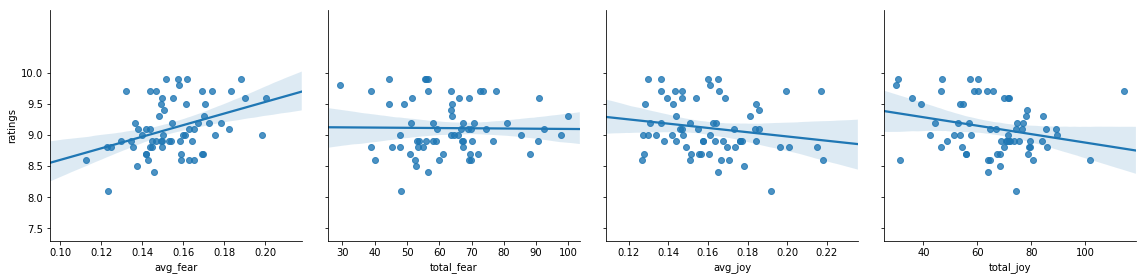

In [7]:
g = sns.PairGrid(df, y_vars=["ratings"], 
                 x_vars=['avg_fear', 'total_fear', 'avg_joy', 'total_joy'], height=4)
g.map(sns.regplot)
g.set(ylim=(7.3, 11), yticks=[7.5, 8, 8.5, 9, 9.5, 10]);


First and foremost, given the number of data points (67 episodes), these are not results that someone could claim as statistically significant. However, these might be enough data points to reveal some trends that are worth discussing. 

These plots don't provide new hard evidence (from what we could get out of the correlation analysis), but it's interesting to see the trends in scatter plots. From this, it's easy to see how `total_fear` doesn't explain the ratings as strongly as `avg_fear`, but both `total_joy` and `avg_joy` do have a similar trend, with a higher correlation for `total_joy`. 

Let's visualize side by side the words that inspire `fear` versus the words that inspire `joy`. 

### Word Clouds

Plotting word clouds is possible by using a method included in `limbic.analysis.words` called `plot_emotions_wordcloud`.

This method shows all terms associated to a `List[TimeEmotion]`. If the parameter `weighted` is set to `True`, then it will take into account the weight of such terms with respect to each emotion. Given that a word can inspire many emotions, it could be the case that `fear`, `anger` and `sadness` are all included in the list of emotions of a single word (e.g. `death` is quantified by `0.574` of `anger`, `0.843` of `fear`, and `0.915` of `sadness`). By considering the weights when plotting the word cloud, some of these repeated terms will be represented by a different intensity (size). 

Now, if the parameter `unique` is set to `True`, it will discard any repeated term between the emotions that are being analyzed. For example, given that `death` inspires `fear`, `anger`, and `sadness`, in case that this term has enough weight to be presented in the word cloud, it would be discarded if the analysis was made simultaneously under these categories.


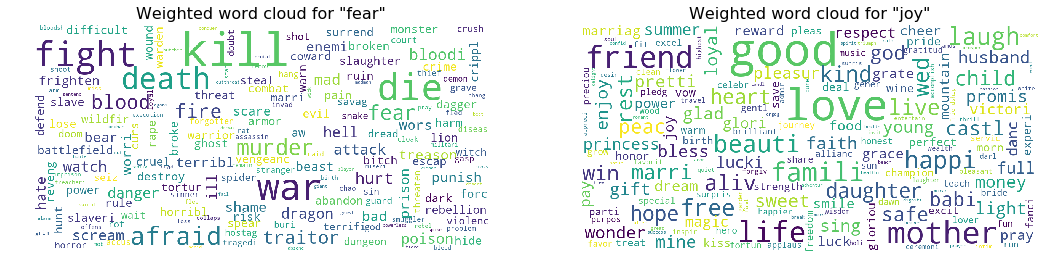

In [8]:
from limbic.analysis.words import plot_emotions_wordclouds

all_emotions = []
for season_data in subtitles_emotions.values():
    for _, emotions in season_data.items():
        all_emotions += emotions

plot_emotions_wordclouds(all_emotions, ['fear', 'joy'], weighted=True)


Based on this, the audience do prefer dialogs with more terms like `war`, `fight` or `afraid` rather than `friend`, `love`, or `mother`. Maybe GRRM Martin said it best in the book `A Dance with Dragons`: 

```
"Words are wind, even words like love and peace. I put more trust in deeds."
```

With this quote, he explains perfectly the observed effect. Words like `love` and `peace` (clearly `joy` inducing words) are proven to be empty, non lasting or at risk (at least in the show), while wods like `war` or `fight` are indeed actions that will undoubtely have some very real effect and often painful consecuences to the characters. In summary, you could say that audiences will give higher ratings to episodes where there's more action and less empty words. 

However, there's an important factor we need isolate before finishing this discussion. Why `sadness` and `anger` do not explain the ratings, when words like `death` are indeed present in those emotions as well? 

Let's review side by side all terms for `anger`, `sadness`, `fear`, and `joy` keeping the ones that are unique per emotion. 


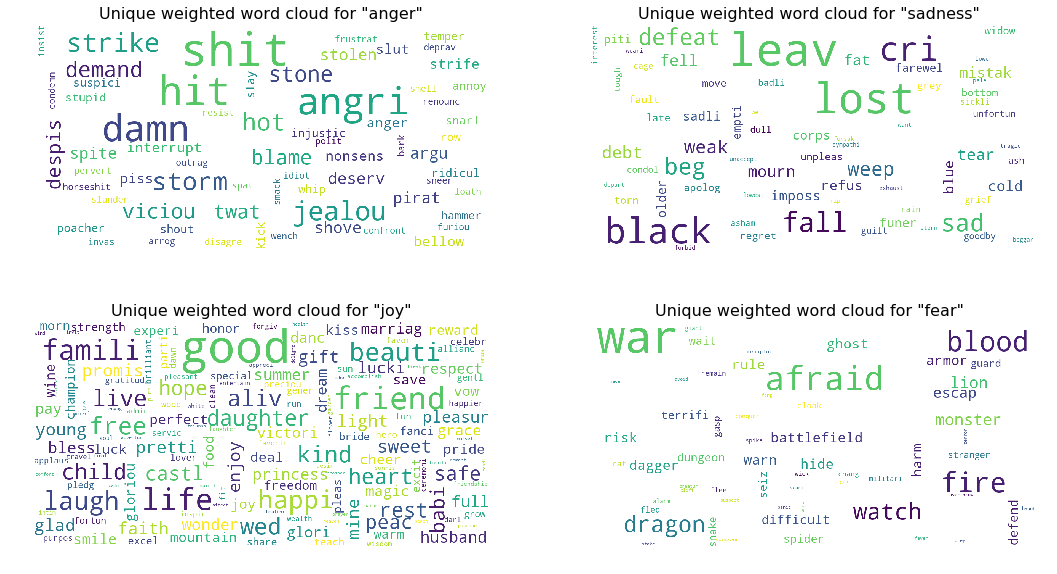

In [9]:
plot_emotions_wordclouds(all_emotions, lb.lexicon.categories, weighted=True, unique=True)


Words in `anger` plot seem to be mostly related "short term" actions (e.g. `hit`), swearing (e.g. `shit`), and specific feelings (`jealou`). Words in the `sadness` plot seem to be associated to the aftermath of important events (`lost`, `sad`). However, it can be argued that the words included exclusively in `fear` category, are the ones associated to the actual events that will cause sadness or anger.


### Emotions over time

Some further analysis can be done by looking at how emotions evolve over time within episodes. For this, some methods are included in `limbic.utils.series`, where the two main methods for this are `features.all_moving_windows` and `plot.plot_emotion_all_episodes`. 

The first is a method that generated time series for moving windows across all episodes for each season, this will return the total per emotion category in windows of 300 seconds in steps of 120 seconds to be analyzed or plotted later.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

The second method is a plotting tool that allows to visualize how emotions evolve through the whole series in a small chart where every column is a season and every row is an episode. The idea of such visualization is that is easy to identify emotional spikes, which could point to important plot developments or twists.

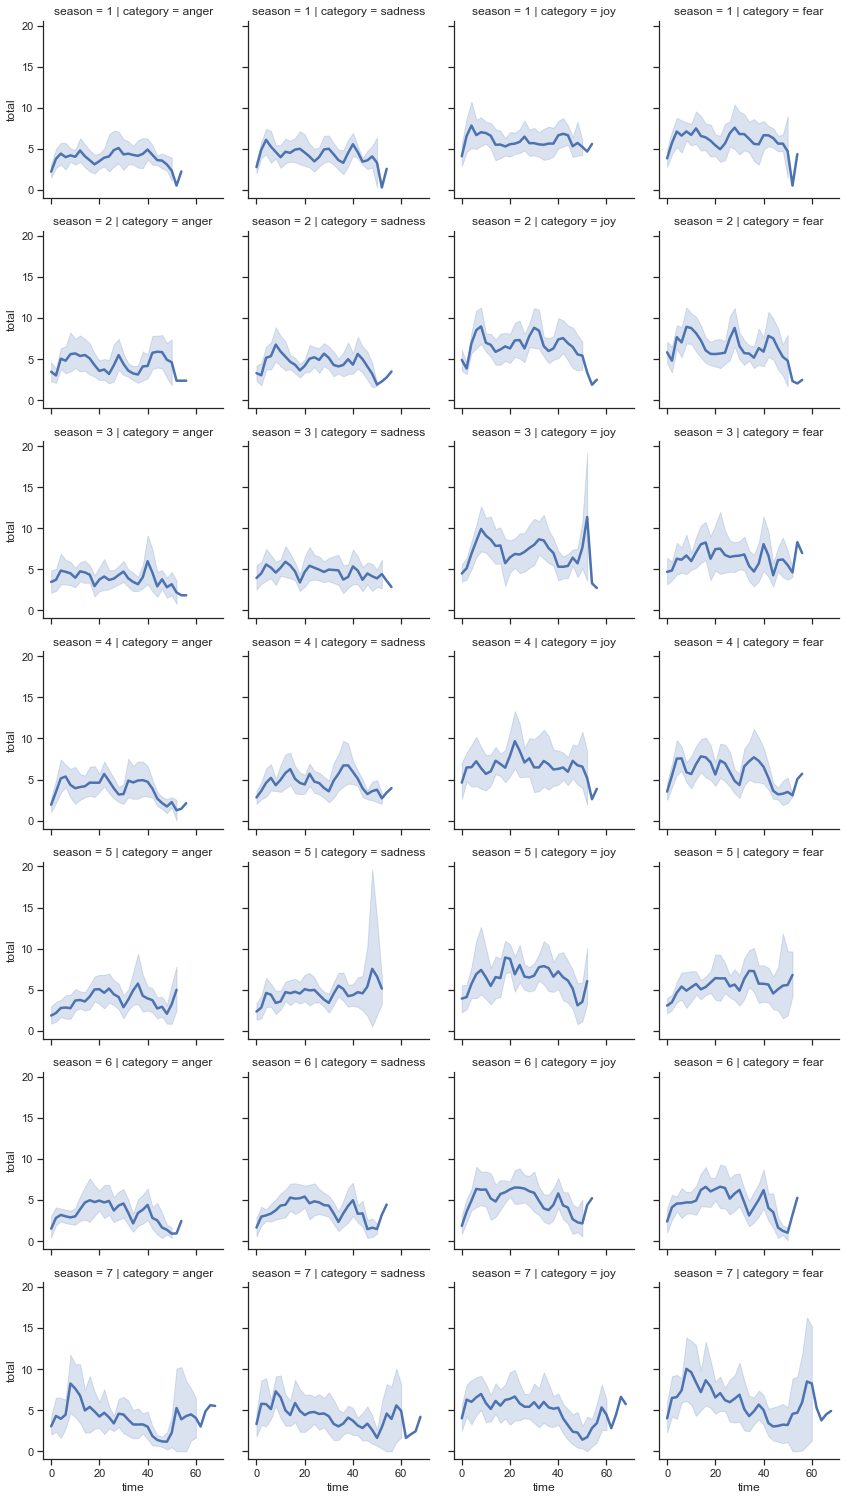

In [10]:
from limbic.analysis.series.features import all_moving_windows

df_moving_windows = all_moving_windows(subtitles_emotions, lb.lexicon.categories)
sns.set(style='ticks')
g = sns.FacetGrid(df_moving_windows, col='category', row='season')
g.map(sns.lineplot, 'time', 'total', linewidth=2.5)
plt.show()


Aboce you can see how each emotion is distributed per season. There are particularly interesting patterns on how `joy`, `sadness` and `fear` have some spikes in season 3, season 5, and season 7 respectively. 

I invite you to correlate these patterns together with the ones presented below, which is the same but all emotions are fleshed out for each episode of each season. Here, each column represent a season and row an episode.

This [guide](https://www.reddit.com/r/asoiaf/comments/bbg2jp/spoilers_main_game_of_thrones_most_thorough_guide/) (thanks to [jjadjjadj](https://www.reddit.com/user/jjadjjadj) for this madness!) can help you go through certain episodes and see how some of the main events are actually represented by the emotions variations. 

For example, you can see above a spike in sadness in season 5. Below, in the sadness chart, you can see in row 10 and column 5 a high spike a little before the end of the episode. If you follow the insane guide above, this episode corresponds to `S5E10 "Mother's Mercy"` (column 50), which is when Cercei's walk of atonement happened, and the word `shame` was said a quite a lot (`shame` has sadness score `0.594`).

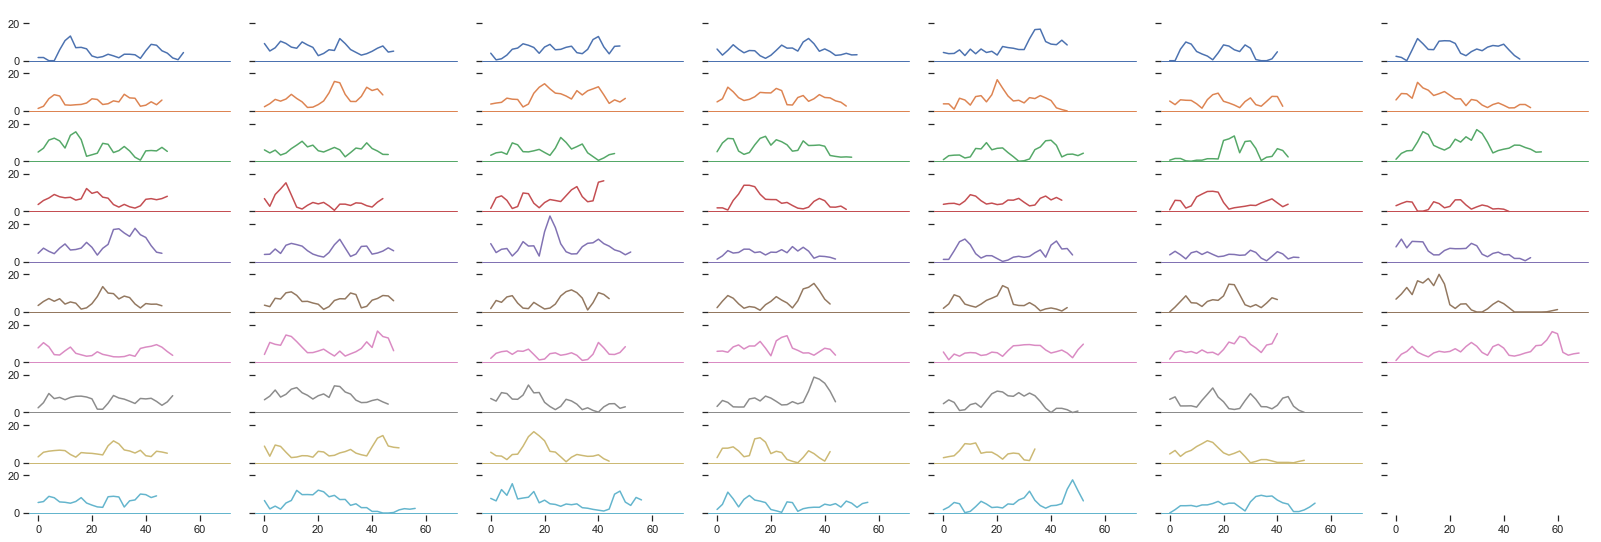

In [11]:
from limbic.analysis.series.plot import plot_emotion_all_episodes

plot_emotion_all_episodes(subtitles_emotions, 'fear')

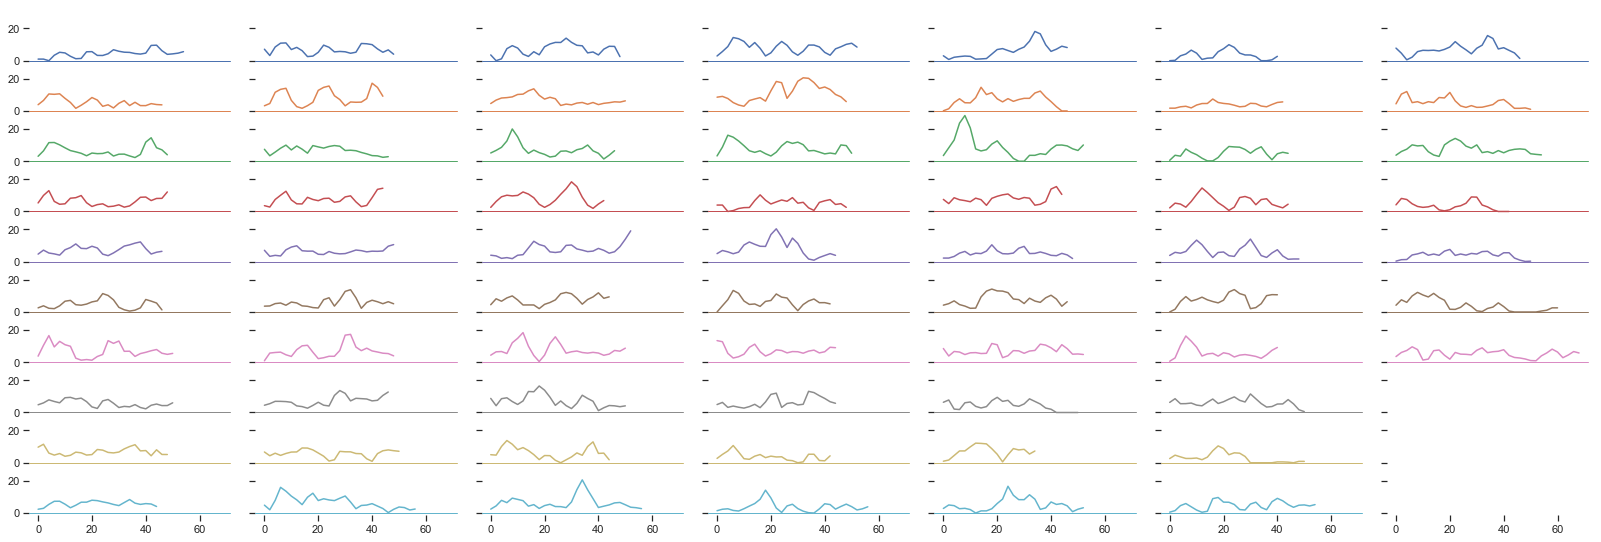

In [12]:
plot_emotion_all_episodes(subtitles_emotions, 'joy')

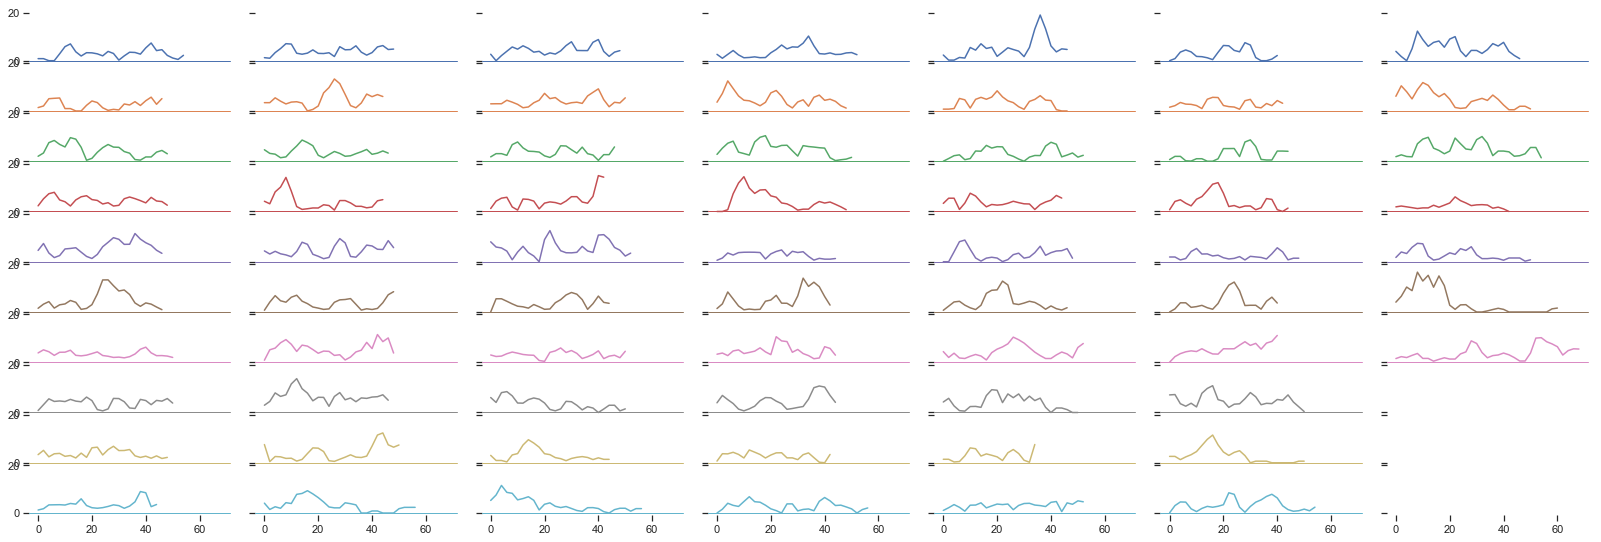

In [13]:
plot_emotion_all_episodes(subtitles_emotions, 'anger')

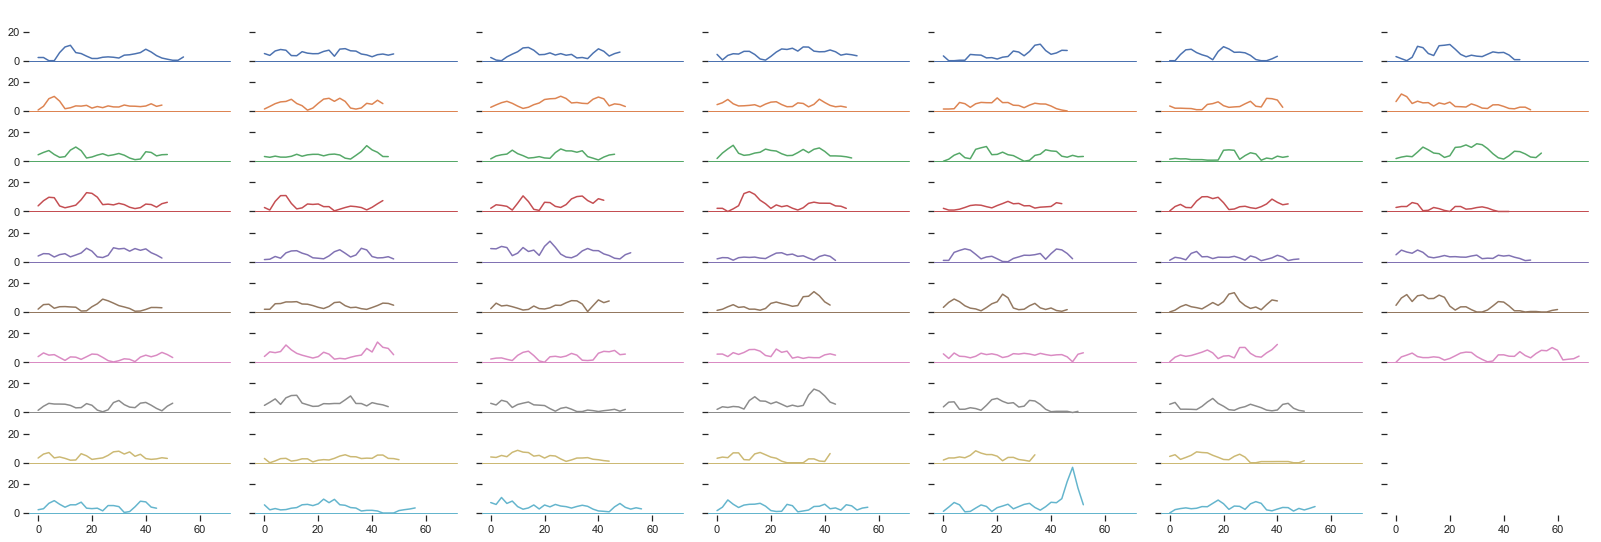

In [14]:
import warnings
warnings.filterwarnings('ignore')
plot_emotion_all_episodes(subtitles_emotions, 'sadness')